In [1]:
import tensorflow as tf
import datetime

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
from src.extract_to_df import extract_to_df
from build_models import create_cnn4
from src.metric_notes import metric_note

In [3]:
#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')

In [5]:
train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')

In [6]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

In [7]:
pixel = 224
size = f'{pixel}x{pixel}'

In [8]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size = (pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size=(pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel,pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)


Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [9]:
metrics = metric_note(train_images, test_images, valid_images)

In [17]:
def create_model_2(node, dropout, learning):
    cnn4 = Sequential([
        Conv2D(node, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*2, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*3, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*4, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout*4),
        Flatten(),
        Dense(node, activation = 'relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning)
    cnn4.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])
    return cnn4

In [10]:
def create_log_path(name):
    log_dir = "logs/fit/" + f'{name}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return log_dir
    
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True)

In [11]:
final_model = create_cnn4(32, 0.1, 0.001, pixel)

final_model.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4_best'), histogram_freq=1)],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 83s 319ms/step - loss: 0.1918 - accuracy: 0.9266 - true_positives: 14735.0000 - true_negatives: 13294.0000 - false_positives: 1206.0000 - false_negatives: 1015.0000 - val_loss: 1.1304 - val_accuracy: 0.5524 - val_true_positives: 3480.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 2820.0000 - val_false_negatives: 0.0000e+00
Epoch 2/1000
237/237 [==============================] - 75s 308ms/step - loss: 0.1405 - accuracy: 0.9459 - true_positives: 15032.0000 - true_negatives: 13581.0000 - false_positives: 919.0000 - false_negatives: 718.0000 - val_loss: 1.2714 - val_accuracy: 0.6413 - val_true_positives: 3480.0000 - val_true_negatives: 560.0000 - val_false_positives: 2260.0000 - val_false_negatives: 0.0000e+00
Epoch 3/1000
237/237 [==============================] - 71s 291ms/step - loss: 0.1319 - accuracy: 0.9497 - true_positives: 15100.0000 - true_negatives: 13628.0000 - false_positives: 872.0000 - false_negatives: 650.

99/99 [==============================] - 101s 1s/step - loss: 0.0557 - accuracy: 0.9798 - true_positives: 3442.0000 - true_negatives: 2731.0000 - false_positives: 89.0000 - false_negatives: 38.0000


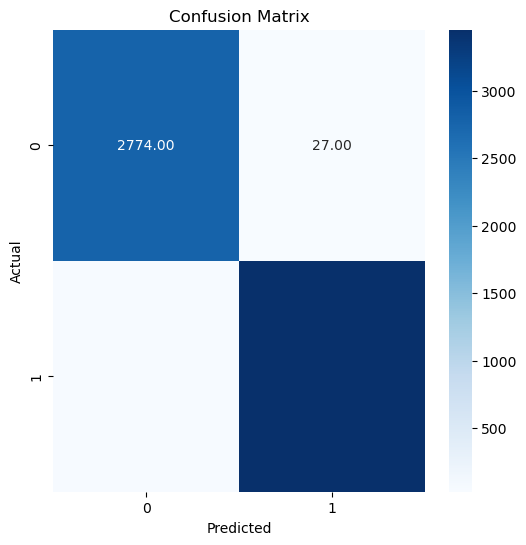

In [14]:
metrics.evaluate(final_model, 'Final Model', size)

In [15]:
final_model.save_weights('./Models/CNN4_best')

In [16]:
metrics.printout.to_csv(f'Dataframes/{size}Final_Model.csv')

In [17]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,Final Model,224x224,0.049455,0.980893,15636.0,14036.0,464.0,114.0,0.033313,0.988413,3453.0,2774.0,46.0,27.0,0.053145,0.980952,3446.0,2734.0,86.0,34.0
1,Final Model,224x224,0.048311,0.981554,15636.0,14056.0,444.0,114.0,0.033313,0.988413,3453.0,2774.0,46.0,27.0,0.055655,0.979841,3442.0,2731.0,89.0,38.0
